[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana6/2_ValuacionOpciones_MonteCarlo.ipynb)

# Simulación Monte Carlo para valuación de Opciones

En esta clase veremos como utilizar el método de muestre MonteCarlo para dar un precio a nuestras opciones de tipo Call Europeo.

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

import yfinance as yf
import pandas as pd

# Simulación por caminos (datos sintéticos)

La ecuación diferencial estocástica que define el camino seguido por un activo es:

$$ dS_t = \mu \, dt + \gamma \, dW_t, $$

donde $S_t$ representa el precio del activo al tiempo t, $\mu$ es el retorno anual esperado, $\gamma$ representa la *volatilidad implicita* del mercado.

In [ ]:
class European_Call_Payoff:

    def __init__(self, strike):
        self.strike = strike

    def get_payoff(self, stock_price):
        if stock_price > self.strike:
            return stock_price - self.strike
        else:
            return 0

In [ ]:
class GeometricBrownianMotion:

    def simulate_paths(self):
        while(self.T - self.dt > 0):
            dWt = np.random.normal(0, math.sqrt(self.dt))  # Movimiento Browniano
            dYt = self.drift*self.dt + self.volatility*dWt  # Cambio/Delta del precio
            self.current_price += dYt  # Agregar el cambio al precio actual
            self.prices.append(self.current_price)  # Agregar nuevo precio a la serie de tiempo
            self.T -= self.dt  # Tomar en cuenta el cambio del tiempo

    def __init__(self, initial_price, drift, volatility, dt, T):
        self.current_price = initial_price
        self.initial_price = initial_price
        self.drift = drift
        self.volatility = volatility
        self.dt = dt
        self.T = T
        self.prices = []
        self.simulate_paths()

# Paréntesis Culturas: POO (si es necesario)

In [ ]:
class ObjetoBasico:
  def __init__(self, una_caracteristica):
    self.caracteristica = una_caracteristica

In [ ]:
a = ObjetoBasico(6)

In [ ]:
a.caracteristica

6

## Parámetros artificiales

In [ ]:
paths = 5
initial_price = 100
drift = .5
volatility = .01
dt = 1/360
T = 30/360
price_paths = []

In [ ]:
# Generar un conjunto de caminos
for i in range(0, paths):
    price_paths.append(GeometricBrownianMotion(initial_price, drift, volatility, dt, T).prices)

In [ ]:
call_payoffs = []
ec = European_Call_Payoff(100) # Le pasamos el precio acordado en el contrato (STRIKE)
risk_free_rate = .01
for price_path in price_paths:
    call_payoffs.append(ec.get_payoff(price_path[-1])/(1 + risk_free_rate))  
    # Vemos el último precio simulado y comparamos con el precio del contrato para saber si ganamos algo o es un cero.

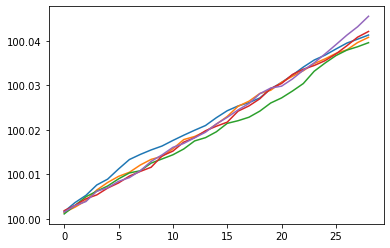

In [ ]:
# Visualicación de los caminos
for price_path in price_paths:
    plt.plot(price_path)
plt.show()

In [ ]:
print(np.average(call_payoffs))  # Comentar sobre como se venden las opciones en el mercado, por bloques

0.014986070706597484


## Ésta solución tiene un pequeño inconveniente, que necesita la "volatilidad implicita."

# Simulación Monte Carlo

In [ ]:
data = yf.download(
        # Lista de tickers o puede ser un string
        tickers = "GOOGL ^IRX",

        # Parámetro "period", tambien se puede utilizar start/end
        # periodos válidos: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (opcional, default es '1mo')
        period = "1y",

        # Peidr datos por intervalo (incluye intradía si es menor a 60 days)
        # intervalos válidos: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (opcional, default es '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (opcional, default es 'column')
        # group_by = 'ticker',
    ).loc[:, 'Adj Close']
data

[*********************100%***********************]  2 of 2 completed


,GOOGL,^IRX
Date,,
2022-01-19 00:00:00-05:00,NaN,0.165
2022-01-20 00:00:00-05:00,133.307495,0.168
2022-01-21 00:00:00-05:00,130.351501,0.158
2022-01-24 00:00:00-05:00,130.804001,0.155
2022-01-25 00:00:00-05:00,126.934998,0.185
...,...,...
2023-01-12 00:00:00-05:00,91.129997,4.475
2023-01-13 00:00:00-05:00,92.120003,4.488
2023-01-17 00:00:00-05:00,91.290001,4.493


Crea un simulador de Movimiento Browniano Geométrico.

$$ 
S_T = S_0 \exp \left[ \left( r - \dfrac{\sigma^2}{2} \right) T + \sigma\epsilon\sqrt{T}  \right],
$$
donde $\epsilon$ es una simulación de una Normal estándar.

Ésta ecuación es la que nos dará la simulación del precio del del activo en el futuro al llevar a cabo simulaciones de variables aleatorias normales. Esto nos ayudará e encontrar el precio de la opción. 

Como extra, solucionar esta ecuación es bastante complejo, pero se puede hacer con una herramienta llamada ecuación de Black-Scholes.

In [ ]:
data

,GOOGL,^IRX
Date,,
2022-01-19 00:00:00-05:00,NaN,0.165
2022-01-20 00:00:00-05:00,133.307495,0.168
2022-01-21 00:00:00-05:00,130.351501,0.158
2022-01-24 00:00:00-05:00,130.804001,0.155
2022-01-25 00:00:00-05:00,126.934998,0.185
...,...,...
2023-01-12 00:00:00-05:00,91.129997,4.475
2023-01-13 00:00:00-05:00,92.120003,4.488
2023-01-17 00:00:00-05:00,91.290001,4.493


In [ ]:
# Renombrar columna
data.rename(columns={'^IRX':'IRX'}, inplace=True)

# Convertir un porcentaje a número
data['IRX'] = data['IRX']/100

# Calculo de log-retornos
data['Vol. GOOGL'] = np.nan
data['log_ret'] = np.log(data['GOOGL']) - np.log(data['GOOGL'].shift(1))

# Calculando la volatilidad de las acciones de GOOGLE
fechas_vol = data.index
for cada_fecha in fechas_vol[125:]:
    data_for_vol = fechas_vol[(cada_fecha - fechas_vol < pd.Timedelta(days=180)) & (cada_fecha - fechas_vol >= pd.Timedelta(days=0))] # 120 dias para 6 meses
    data.loc[cada_fecha, 'Vol. GOOGL'] = np.std(data['log_ret'][data_for_vol].values, ddof=1)*np.sqrt(252)


In [ ]:
data

,GOOGL,IRX,Vol. GOOGL,log_ret
Date,,,,
2022-01-19 00:00:00-05:00,NaN,0.00165,NaN,NaN
2022-01-20 00:00:00-05:00,133.307495,0.00168,NaN,NaN
2022-01-21 00:00:00-05:00,130.351501,0.00158,NaN,-0.022424
2022-01-24 00:00:00-05:00,130.804001,0.00155,NaN,0.003465
2022-01-25 00:00:00-05:00,126.934998,0.00185,NaN,-0.030025
...,...,...,...,...
2023-01-12 00:00:00-05:00,91.129997,0.04475,0.388766,-0.004270
2023-01-13 00:00:00-05:00,92.120003,0.04488,0.387607,0.010805
2023-01-17 00:00:00-05:00,91.290001,0.04493,0.385682,-0.009051


In [ ]:
un_dato = data.iloc[-3,:].copy()
un_dato

GOOGL         91.290001
IRX            0.044930
Vol. GOOGL     0.385682
log_ret       -0.009051
Name: 2023-01-17 00:00:00-05:00, dtype: float64

Recordemos la fórmula:
$$ 
S_T = S_0 \exp \left[ \left( r - \dfrac{\sigma^2}{2} \right) T + \sigma\epsilon\sqrt{T}  \right],
$$


In [ ]:
valores = np.array([])

for i in range(10000):

  K = un_dato.GOOGL - 10
  normal = np.random.standard_normal(1)

  St = un_dato.GOOGL*np.exp((un_dato.IRX - 0.5*un_dato['Vol. GOOGL']**2)*30/360 + un_dato['Vol. GOOGL']*normal*np.sqrt(30/360))

  valores = np.append(valores, max(St - K,0))

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
valores

In [ ]:
valores.mean()

10.98006573617211

# Ejercicio 1

Adaptar el código para que a cada entrada del DataFrame le calculen el valor de la opción, como en la clase pasada

In [ ]:
from tqdm import tqdm

In [ ]:
# Espacio para el ejercicio

data_cop = data[data['Vol. GOOGL'].notnull()].copy()
data_cop['precio_call'] = np.nan

for index in tqdm(data_cop.index):
  valores = np.array([])
  un_dato = data_cop.loc[index, :]
  
  for i in range(10000):

    K = un_dato.GOOGL + 10
    normal = np.random.standard_normal(1)

    St = un_dato.GOOGL*np.exp((un_dato.IRX - 0.5*un_dato['Vol. GOOGL']**2)*30/360 + un_dato['Vol. GOOGL']*normal*np.sqrt(30/360))

    valores = np.append(valores, max(St - K,0))

  data_cop.loc[index ,'precio_call'] = valores.mean()




100%|██████████| 127/127 [01:14<00:00,  1.71it/s]


In [ ]:
data_cop

,GOOGL,IRX,Vol. GOOGL,log_ret,precio_call
Date,,,,,
2022-07-20 00:00:00-04:00,113.900002,0.02378,0.392286,0.000791,1.834312
2022-07-21 00:00:00-04:00,114.339996,0.02360,0.391170,0.003856,1.849748
2022-07-22 00:00:00-04:00,107.900002,0.02355,0.397882,-0.057972,1.695338
2022-07-25 00:00:00-04:00,107.510002,0.02393,0.397344,-0.003621,1.620809
2022-07-26 00:00:00-04:00,105.019997,0.02475,0.397609,-0.023433,1.563408
...,...,...,...,...,...
2023-01-12 00:00:00-05:00,91.129997,0.04475,0.388766,-0.004270,1.033294
2023-01-13 00:00:00-05:00,92.120003,0.04488,0.387607,0.010805,1.132204
2023-01-17 00:00:00-05:00,91.290001,0.04493,0.385682,-0.009051,1.074824


In [ ]:
# Espacio para el ejercicio
def calcular(valor):
  valores = np.array([])
  for i in range(10000):
    K = valor.GOOGL + 10
    normal = np.random.standard_normal(1)

    St = valor.GOOGL*np.exp((valor.IRX - 0.5*valor['Vol. GOOGL']**2)*30/360 + valor['Vol. GOOGL']*normal*np.sqrt(30/360))

    valores = np.append(valores, max(St - K,0))
  return valores.mean()

ejercicio = data[data['Vol. GOOGL'].notnull()].copy()
ejercicio.loc[:, 'columna_extra'] = ejercicio.apply(lambda x: calcular(x), axis=1)
ejercicio

NameError: ignored